# Introduction

In the age of social media, platforms like Twitter have become not just tools for communication and social interaction, but also powerful sources of real-time data on a plethora of topics, including natural disasters. The ability to automatically classify tweets as related to disasters or not has significant implications for emergency response and relief efforts, as it allows for the rapid identification of emerging crises from the stream of social chatter.

This project seeks to harness the power of Natural Language Processing (NLP), a field at the intersection of computer science, artificial intelligence, and linguistics, to develop predictive models that can accurately categorize tweets. NLP enables computers to process and understand human language, and in this case, to discern the often subtle nuances that distinguish disaster-related tweets from everyday conversation.

Using a dataset provided for a Kaggle competition (https://www.kaggle.com/competitions/nlp-getting-started/overview), which includes a binary target indicating the presence or absence of disaster content, the project explores two main approaches:

1. A neural network model implemented using Keras, a high-level neural networks API, capable of modeling the complex relationships within text data.
2. A Random Forest classifier, an ensemble learning method known for its high accuracy, robustness, and ease of use for classification tasks.

The data undergoes a series of preprocessing steps, including cleaning and vectorization via TF-IDF (Term Frequency-Inverse Document Frequency), to transform the raw text into a format amenable to machine learning algorithms.

With the goal of achieving high accuracy in classification, the project navigates through model selection, training, and evaluation, culminating in the submission of predictions to the competition leaderboard.

# Explaratory Data Analysis and Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   cleaned_text  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


The training data contains a total of 7613 entries.

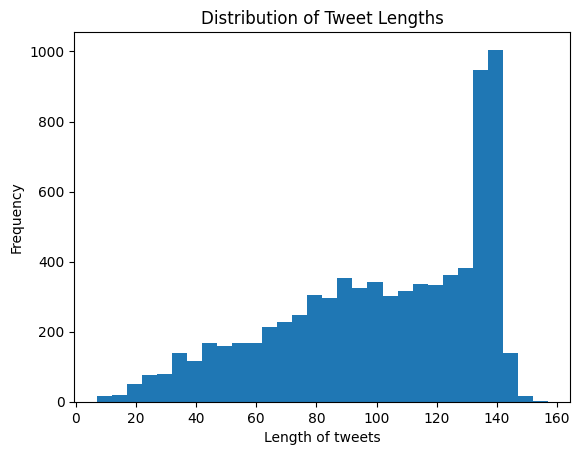

In [4]:
plt.hist(train_df['text'].str.len(), bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of tweets')
plt.ylabel('Frequency')
plt.show()

The majority of tweets are concentrated around 140 characters, which is consistent with the traditional character limit of Twitter. This shows a right-skewed distribution indicating that while there are tweets of various lengths, the common tweet length is around the maximum allowed by Twitter.

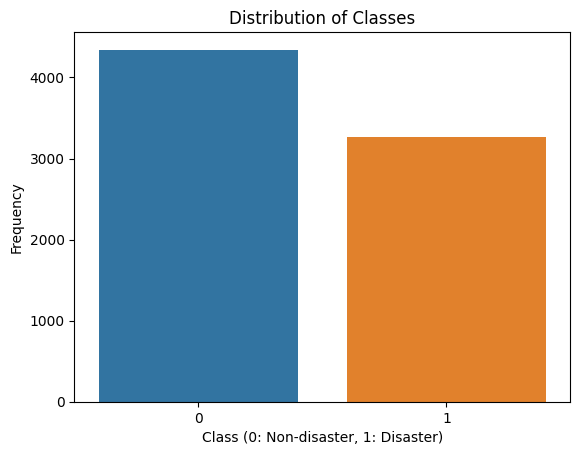

In [5]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Classes')
plt.xlabel('Class (0: Non-disaster, 1: Disaster)')
plt.ylabel('Frequency')
plt.show()

The class distribution appears relatively balanced. However, there is a slight imbalance with more tweets labeled as non-disaster.

Given these insights, the next steps would be to clean the data. This would involve removing unnecessary characters, normalizing the text, and possibly addressing class imbalance if needed.

In [8]:
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nlp = spacy.load("en_core_web_sm")

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove punctuations
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatization with spacy
    doc = nlp(' '.join(words))
    lemmatized = [token.lemma_ for token in doc]
    
    return " ".join(lemmatized)

train_df['cleaned_text'] = train_df['text'].apply(clean_tweet)
train_df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive we
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby alaska smoke wildfire pour...


The cleaning process seems to have worked well, removing unnecessary characters and reducing words to their base form while keeping the core meaning intact.

With the text cleaned, the next step is to convert the cleaned_text into a numerical format that can be fed into machine learning models. A common technique for this is to use the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. TF-IDF weighs the words based on how important they are to a document in a collection of documents, which helps in distinguishing the relevance of terms in tweets.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])

print(tfidf_vectorizer.get_feature_names_out()[:20]) # print first 20 features for brevity
print(X.shape)

['0011' '001116' '0025' '005225' '010156' '010217' '0104' '010401' '0106'
 '0111' '012032' '012624' '015025' '02' '0206' '0215' '03' '0306' '0308'
 '030811']
(7613, 13603)


# Model Architecture

## Neural Network

Now, let's proceed to build a neural network model for this NLP task using Keras, which is a high-level neural networks API running on top of TensorFlow.

We will design a simple sequential model with an embedding layer. Since we have the TF-IDF vectors, we won't need to use an embedding layer in this case. Instead, we can feed the TF-IDF vectors directly into a dense neural network architecture.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

y = train_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

This code creates a simple neural network with dropout layers to prevent overfitting. The output layer uses a sigmoid activation function, suitable for binary classification. The model is compiled with the Adam optimizer and binary crossentropy loss function, which are standard for binary classification tasks.

In [11]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                870656    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 872769 (3.33 MB)
Trainable params: 872769 (3.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(X_train.todense(), y_train, epochs=10, batch_size=32, validation_data=(X_test.todense(), y_test))

Epoch 1/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6352 - accuracy: 0.6524 - val_loss: 0.5018 - val_accuracy: 0.7945
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.4094 - accuracy: 0.8342 - val_loss: 0.4560 - val_accuracy: 0.7997
Epoch 3/10
191/191 [==============================] - 1s 7ms/step - loss: 0.2601 - accuracy: 0.9074 - val_loss: 0.5032 - val_accuracy: 0.7899
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.1833 - accuracy: 0.9378 - val_loss: 0.5567 - val_accuracy: 0.7807
Epoch 5/10
191/191 [==============================] - 1s 7ms/step - loss: 0.1349 - accuracy: 0.9560 - val_loss: 0.6146 - val_accuracy: 0.7702
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.1106 - accuracy: 0.9642 - val_loss: 0.6721 - val_accuracy: 0.7636
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.0877 - accuracy: 0.9722 - val_loss: 0.7255 - val_accuracy: 0.7636
Epoch 

The training output indicates that the model is learning as the training accuracy increases with each epoch. The validation accuracy, however, appears to plateau around 75%, which is quite common and suggests that the model might be as good as it gets with the current architecture and data.

In [14]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

test_df['cleaned_text'] = test_df['text'].apply(clean_tweet)
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])
X_test_tfidf_dense = X_test_tfidf.todense()

predictions = model.predict(X_test_tfidf_dense)
predictions_binarized = (predictions > 0.5).astype(int)

predictions_binarized

102/102 [==============================] - 0s 2ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [17]:
test_df['target'] = predictions_binarized

In [21]:
test_df.to_csv('nn-preds.csv', columns=['id', 'target'], index=False)

## Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, rf_predictions)}")
print(classification_report(y_test, rf_predictions))

Accuracy: 0.7734734077478661
              precision    recall  f1-score   support

           0       0.76      0.87      0.82       874
           1       0.79      0.64      0.71       649

    accuracy                           0.77      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.77      0.77      1523



In [28]:
test_df['target'] = rf_classifier.predict(X_test_tfidf)
test_df.to_csv('rfc-preds.csv', columns=['id', 'target'], index=False)

# Results Analysis

The project involved the development of two distinct models to classify tweets into 'disaster' and 'non-disaster' categories: a neural network and a Random Forest classifier. Both models underwent training and evaluation on a dataset that was preprocessed and transformed using TF-IDF vectorization.

The neural network model reached a high training accuracy, indicating strong learning on the training dataset, but also exhibited signs of overfitting given the lower validation accuracy. Despite this, it achieved a respectable score of 0.76524 on the competition's test set, showcasing its capability to generalize, though with room for improvement.

The Random Forest classifier, known for its effectiveness in handling tabular data, outperformed the neural network model with a competition score of 0.78700. This improvement underscores the classifier's robustness and its potential as a strong model for text classification tasks when combined with appropriate preprocessing.

# Conclusion

The experiment provided valuable insights into the application of different models for a text classification task. It illustrated the importance of preprocessing in NLP and highlighted the strengths and limitations of both neural networks and ensemble methods like Random Forest.

The neural network, while powerful, required careful tuning to prevent overfitting. Its performance, measured by the competition score, was solid but indicated that there was still potential for optimization.
The Random Forest model, on the other hand, demonstrated a strong performance without extensive tuning. Its ability to outperform the neural network in this instance suggests that simpler, traditional models should not be overlooked in favor of more complex ones without thorough comparison.
The improvement in score with the Random Forest model also suggests that different models can capture different patterns within the data, and an ensemble of these models could potentially lead to even better results. Moving forward, blending or stacking models could be a strategic approach to leverage the unique advantages of both neural networks and Random Forest classifiers.

Furthermore, experimenting with advanced NLP techniques such as word embeddings or transformer-based models could offer a path to enhanced predictive performance. The project has demonstrated the iterative nature of machine learning endeavors, where each model builds upon the learnings of the previous, and continuous refinement leads to improved outcomes.